In [1]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
os.chdir(config["PATH"]["project"])

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [4]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("US_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

Connect to postgres; read stations table from postgres DB "covid"

# Load data

## Load weather stations location data from postgres DB

In [5]:
stations = spark.read.format("jdbc")\
    .option("url" , "jdbc:postgresql://localhost:5432/covid")\
    .option("dbtable", "world_stations")\
    .option("user","sb")\
    .option("password", "sb")\
    .load()

In [6]:
stations.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- station_name: string (nullable = true)



In [7]:
# Puerto Rico, Virgin Islands, Guam, Samoa
unincorporated_territories = ["RQ", "VQ", "CQ", "AQ"]
US_territories = unincorporated_territories[:]
US_territories.append("US")

In [8]:
US_stations = stations[ stations["station_id"][0:2].isin(US_territories) ]

In [9]:
%%time
US_stations.count()

CPU times: user 2.23 ms, sys: 339 µs, total: 2.57 ms
Wall time: 3.78 s


65478

## Load world wide weather info from csv file

In [10]:
weather_path = os.path.join(config["PATH"]["project"], "DATA/WEATHER/2020.csv" )
weather_2020 = spark.read.load(weather_path, format = "csv", sep = ",",
                            schema = "station_id string, date string, measured string, v1 string, v2 string, v3 string, v4 string, v5 string")

In [11]:
weather_2020.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- v1: string (nullable = true)
 |-- v2: string (nullable = true)
 |-- v3: string (nullable = true)
 |-- v4: string (nullable = true)
 |-- v5: string (nullable = true)



In [12]:
%%time
nb_weather_records = weather_2020.count()
nb_weather_records

CPU times: user 5.99 ms, sys: 294 µs, total: 6.28 ms
Wall time: 14.3 s


34320857

In [13]:
%%time
weather_2020.show(10)

+-----------+--------+--------+---+----+----+---+----+
| station_id|    date|measured| v1|  v2|  v3| v4|  v5|
+-----------+--------+--------+---+----+----+---+----+
|AEM00041194|20200101|    PRCP|  0|null|null|  S|null|
|AEM00041194|20200101|    TAVG|217|   H|null|  S|null|
|AE000041196|20200101|    TMIN|168|null|null|  S|null|
|AE000041196|20200101|    PRCP|  0|   D|null|  S|null|
|AE000041196|20200101|    TAVG|211|   H|null|  S|null|
|AEM00041217|20200101|    TAVG|205|   H|null|  S|null|
|AEM00041218|20200101|    TMIN|148|null|null|  S|null|
|AEM00041218|20200101|    TAVG|199|   H|null|  S|null|
|AFM00040990|20200101|    TMAX|174|null|null|  S|null|
|AFM00040990|20200101|    TMIN| 45|null|null|  S|null|
+-----------+--------+--------+---+----+----+---+----+
only showing top 10 rows

CPU times: user 2.67 ms, sys: 404 µs, total: 3.07 ms
Wall time: 642 ms


# Data analysis

## Join weather with station, to then filter and keep only US stations

In [14]:
weather_2020 = weather_2020.join( US_stations, ["station_id"])

In [15]:
weather_2020.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- v1: string (nullable = true)
 |-- v2: string (nullable = true)
 |-- v3: string (nullable = true)
 |-- v4: string (nullable = true)
 |-- v5: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- station_name: string (nullable = true)



In [16]:
%%time
weather_2020 = weather_2020.filter( weather_2020.station_id.isNotNull() )

CPU times: user 0 ns, sys: 5.53 ms, total: 5.53 ms
Wall time: 161 ms


In [17]:
%%time
nb_weather_record_US = weather_2020.count()
nb_weather_record_US

CPU times: user 20.2 ms, sys: 1.86 ms, total: 22 ms
Wall time: 1min 33s


25176049

In [ ]:
# 25074507
# 0.7305909348359221

In [18]:
nb_weather_record_US/nb_weather_records


0.733549543940584

In [ ]:
%%time
weather_2020.show(10)

## check possible values for measurement columns

### v2 : measurement flag

In [19]:
# Measurement flag ??
%%time
weather_2020.select("v2").distinct().count()

UsageError: Line magic function `%%time` not found.


In [ ]:
%%time
v2_distinct = weather_2020.select("v2").distinct().collect()

### v3 : Q flag (quality of measurement)

In [20]:
# Q Flag : quality of measurement
v3_distinct = weather_2020.select("v3").distinct().collect()
len(v3_distinct)

15

In [21]:
stat_quality = weather_2020.groupBy("v3").count().orderBy("count").collect()

In [22]:
stat_quality

[Row(v3='T', count=17),
 Row(v3='W', count=70),
 Row(v3='R', count=107),
 Row(v3='N', count=167),
 Row(v3='M', count=213),
 Row(v3='K', count=303),
 Row(v3='G', count=391),
 Row(v3='X', count=1446),
 Row(v3='Z', count=1848),
 Row(v3='S', count=1852),
 Row(v3='O', count=2194),
 Row(v3='D', count=3449),
 Row(v3='L', count=8138),
 Row(v3='I', count=9966),
 Row(v3=None, count=25145888)]

In [23]:
def none_to_str(a):
    if a is None:
        return ""
    else :
        return a

for item in sorted(v3_distinct, key = lambda a : none_to_str(a[0])):
    print(item)

Row(v3=None)
Row(v3='D')
Row(v3='G')
Row(v3='I')
Row(v3='K')
Row(v3='L')
Row(v3='M')
Row(v3='N')
Row(v3='O')
Row(v3='R')
Row(v3='S')
Row(v3='T')
Row(v3='W')
Row(v3='X')
Row(v3='Z')


### v4 : S flag (source of measurement)

In [24]:
# S flag : source of measurement
v4_distinct = weather_2020.select("v4").distinct().collect()
len(v4_distinct)

9

In [25]:
for item in sorted(v4_distinct, key = lambda a : none_to_str(a[0])):
    print(item)

Row(v4='7')
Row(v4='H')
Row(v4='N')
Row(v4='R')
Row(v4='S')
Row(v4='T')
Row(v4='U')
Row(v4='W')
Row(v4='Z')


### v5 : hour ???

In [26]:
# HOUR ????
v5_distinct = weather_2020.select("v5").distinct().collect()
len(v5_distinct)

40

In [27]:
for item in sorted(v5_distinct, key = lambda a : none_to_str(a[0])):
    print(item)

Row(v5=None)
Row(v5='0100')
Row(v5='0400')
Row(v5='0430')
Row(v5='0500')
Row(v5='0530')
Row(v5='0600')
Row(v5='0630')
Row(v5='0700')
Row(v5='0730')
Row(v5='0800')
Row(v5='0830')
Row(v5='0900')
Row(v5='0930')
Row(v5='1000')
Row(v5='1030')
Row(v5='1100')
Row(v5='1130')
Row(v5='1200')
Row(v5='1300')
Row(v5='1400')
Row(v5='1430')
Row(v5='1500')
Row(v5='1530')
Row(v5='1600')
Row(v5='1630')
Row(v5='1700')
Row(v5='1730')
Row(v5='1800')
Row(v5='1830')
Row(v5='1900')
Row(v5='1930')
Row(v5='2000')
Row(v5='2100')
Row(v5='2130')
Row(v5='2200')
Row(v5='2230')
Row(v5='2300')
Row(v5='2330')
Row(v5='2400')


### Measured elements

In [28]:
l_elements= weather_2020.groupBy("measured").count().orderBy("measured").collect()
l_elements

[Row(measured='AWDR', count=17264),
 Row(measured='AWND', count=360547),
 Row(measured='DAPR', count=80250),
 Row(measured='DASF', count=2),
 Row(measured='EVAP', count=43562),
 Row(measured='MDPR', count=79392),
 Row(measured='MDSF', count=2),
 Row(measured='MNPN', count=20710),
 Row(measured='MXPN', count=21216),
 Row(measured='PGTM', count=78011),
 Row(measured='PRCP', count=7469136),
 Row(measured='PSUN', count=963),
 Row(measured='SN31', count=4957),
 Row(measured='SN32', count=46877),
 Row(measured='SN33', count=4087),
 Row(measured='SN35', count=1262),
 Row(measured='SN36', count=603),
 Row(measured='SN51', count=1694),
 Row(measured='SN52', count=18246),
 Row(measured='SN53', count=2345),
 Row(measured='SN55', count=1056),
 Row(measured='SN56', count=640),
 Row(measured='SNOW', count=4138057),
 Row(measured='SNWD', count=2416217),
 Row(measured='SX31', count=4956),
 Row(measured='SX32', count=47154),
 Row(measured='SX33', count=4083),
 Row(measured='SX35', count=1628),
 Row(mea

In [29]:
sorted(l_elements, key = lambda a :a["count"])

[Row(measured='DASF', count=2),
 Row(measured='MDSF', count=2),
 Row(measured='WT10', count=16),
 Row(measured='WT07', count=123),
 Row(measured='WT09', count=514),
 Row(measured='SN36', count=603),
 Row(measured='SN56', count=640),
 Row(measured='SX56', count=640),
 Row(measured='THIC', count=950),
 Row(measured='TSUN', count=958),
 Row(measured='PSUN', count=963),
 Row(measured='SX36', count=969),
 Row(measured='SN55', count=1056),
 Row(measured='SX55', count=1057),
 Row(measured='SN35', count=1262),
 Row(measured='SX35', count=1628),
 Row(measured='SN51', count=1694),
 Row(measured='SX51', count=1695),
 Row(measured='WT05', count=2105),
 Row(measured='SN53', count=2345),
 Row(measured='SX53', count=2345),
 Row(measured='WT04', count=3124),
 Row(measured='WT11', count=3969),
 Row(measured='SX33', count=4083),
 Row(measured='SN33', count=4087),
 Row(measured='WT06', count=4445),
 Row(measured='SX31', count=4956),
 Row(measured='SN31', count=4957),
 Row(measured='WDFG', count=10539),
 

In [30]:
measurements = ["PRCP","TMAX","TMIN", "TOBS", "SNOW", "SNWD"]

In [31]:
#weather_2020.write.partitionedBy( "date").format("parquet").save("weather_2020_with_stations.parquet")

In [32]:
%%time
weather_2020.select("date").distinct().count()

CPU times: user 15.3 ms, sys: 3.94 ms, total: 19.3 ms
Wall time: 1min 23s


366

## Filter data

### Remove rows with quality control failed

In [33]:
weather_2020 = weather_2020.filter( weather_2020["v3"].isNull())

In [34]:
weather_2020.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- v1: string (nullable = true)
 |-- v2: string (nullable = true)
 |-- v3: string (nullable = true)
 |-- v4: string (nullable = true)
 |-- v5: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- station_name: string (nullable = true)



In [35]:
%%time
weather_2020.select("station_id","date","measured","v1")\
    .write.partitionBy( "date").format("parquet").mode("overwrite").save("weather_2020_with_stations.parquet")

CPU times: user 51.3 ms, sys: 22 ms, total: 73.3 ms
Wall time: 5min 57s


In [36]:
weather_2020.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- v1: string (nullable = true)
 |-- v2: string (nullable = true)
 |-- v3: string (nullable = true)
 |-- v4: string (nullable = true)
 |-- v5: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- station_name: string (nullable = true)



### Check that there is only 1 measurement per (date, station, metric)

In [37]:
too_much_measures = weather_2020.groupBy("date", "station_id", "measured").count().filter( "count > 1")

In [38]:
%%time 
too_much_measures.count()

CPU times: user 10.1 ms, sys: 7.15 ms, total: 17.2 ms
Wall time: 1min 21s


0

In [39]:
weather_2020.groupBy("date").count().orderBy( F.col("count").desc()).show(10)

+--------+-----+
|    date|count|
+--------+-----+
|20200417|71415|
|20200416|71276|
|20200810|71074|
|20201026|70968|
|20201006|70967|
|20201007|70850|
|20200916|70844|
|20200921|70754|
|20200908|70727|
|20200812|70696|
+--------+-----+
only showing top 10 rows



# Specialized vs generic stations

In [35]:
groupby_station_element = weather_2020.groupBy("station_id", "measured").agg( F.count("date").alias("nb_days"))

In [36]:
groupby_station_element.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- nb_days: long (nullable = false)



In [ ]:
df_stations_minnbmeasurements= groupby_station_element.groupBy("station_id").min("nb_days").toPandas()

In [ ]:
df_stations_minnbmeasurements.head()

array([[<AxesSubplot:title={'center':'min(nb_days)'}>]], dtype=object)

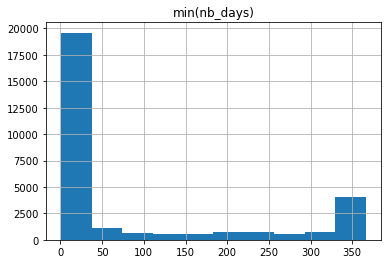

In [137]:
df_stations_minnbmeasurements.hist()

In [ ]:
df_stations_maxnbmeasurements= groupby_station_element.groupBy("station_id").max("nb_days").toPandas()

array([[<AxesSubplot:title={'center':'max(nb_days)'}>]], dtype=object)

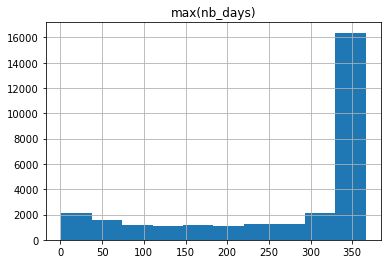

In [138]:
df_stations_maxnbmeasurements.hist()

**Conclusion : most of the stations are specialized in a few elements. For therse elements, they output a measure almost every day. For the other elements, they almost never output a measure.** 

In [ ]:
nb_snowfall_perdate = weather_2020.filter( weather_2020["measured"] == "SNOW").groupBy("date").count().orderBy("date").toPandas()

In [ ]:
#### !!!!!!!!!!! must user .values for constructing series from dataframe with explicit index !!!!!!!!!!
snowfall_serie = pd.Series( nb_snowfall_perdate["count"].values, index =pd.to_datetime(nb_snowfall_perdate["date"]) )

<AxesSubplot:xlabel='date'>

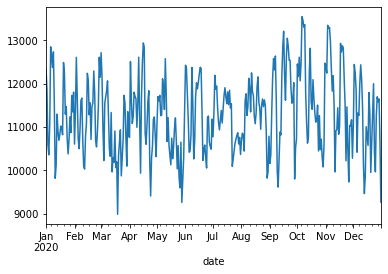

In [134]:
snowfall_serie.plot()

In [135]:
groupby_station_element.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- measured: string (nullable = true)
 |-- nb_days: long (nullable = false)



keep only (station, element) where a measure exist almost everyday 

In [40]:
groupby_station_element_filtered = groupby_station_element.filter( groupby_station_element["nb_days"] >350)

In [39]:
%%time
groupby_station_element_filtered.count()

CPU times: user 18.3 ms, sys: 122 µs, total: 18.4 ms
Wall time: 1min 20s


50108

In [41]:
%%time
groupby_station_element.select("station_id").distinct().count()

CPU times: user 12.8 ms, sys: 3.58 ms, total: 16.4 ms
Wall time: 1min 1s


41051

In [44]:
# stations with at least 1 element with > 350 measurements
filtered_stations = groupby_station_element_filtered.select("station_id").distinct()

In [149]:
np.sqrt(51800)

227.59613353482084

In [155]:
df_stations_minnbmeasurements[ df_stations_minnbmeasurements["min(nb_days)"] > 350].count()

station_id      3305
min(nb_days)    3305
dtype: int64

In [154]:
df_stations_minnbmeasurements.head()

,station_id,min(nb_days)
0,US10keit020,10
1,US10pawn007,20
2,US10perk021,323
3,US10shem003,1
4,US1ARGN0006,2


In [ ]:
select_measures = weather_2020.filter( weather_2020["measured"].isin(measurements ))

In [ ]:
select_measures.count()

In [ ]:
select_measures.printSchema()

Check that there is only 1 measurement (per date, station, metric)

In [ ]:
too_much_measures = select_measures.groupBy("date", "station_id", "measured").count().filter( "count > 1")

In [ ]:
too_much_measures.count()

In [ ]:
select_measures = select_measures.select("station_id", "date", "measured", "v1")\
    .groupBy("date","station_id", "measured")\
    .agg( F.first("v1").alias("v1"))

In [ ]:
select_measures.printSchema()

In [ ]:
pivoted_weather = select_measures.groupBy("station_id", "date").pivot("measured", measurements).agg(F.first("v1").alias("v1"))

In [ ]:
pivoted_weather.count()

In [ ]:
pivoted_weather.show(10)

# Find closest station per fips

In [16]:
gazeeter_county = spark.read.load("gazeeter_counties.csv", format = "csv", sep = ",", header = True)

In [17]:
gazeeter_county.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- state: string (nullable = true)
 |-- county: string (nullable = true)
 |-- fips: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



In [28]:
gazeeter_county = gazeeter_county.withColumn("latitude", F.col("latitude").cast(T.DoubleType()) )\
                        .withColumn("longitude", F.col("longitude").cast(T.DoubleType()) )

In [29]:
gazeeter_county.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- state: string (nullable = true)
 |-- county: string (nullable = true)
 |-- fips: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [30]:
gazeeter_county.take(10)

[Row(_c0='0', state='AL', county='Autauga County', fips='01001', latitude=32.532237, longitude=-86.64644),
 Row(_c0='1', state='AL', county='Baldwin County', fips='01003', latitude=30.659218, longitude=-87.746067),
 Row(_c0='2', state='AL', county='Barbour County', fips='01005', latitude=31.870253, longitude=-85.405104),
 Row(_c0='3', state='AL', county='Bibb County', fips='01007', latitude=33.015893, longitude=-87.127148),
 Row(_c0='4', state='AL', county='Blount County', fips='01009', latitude=33.977358, longitude=-86.56644),
 Row(_c0='5', state='AL', county='Bullock County', fips='01011', latitude=32.101759, longitude=-85.717261),
 Row(_c0='6', state='AL', county='Butler County', fips='01013', latitude=31.751667, longitude=-86.681969),
 Row(_c0='7', state='AL', county='Calhoun County', fips='01015', latitude=33.770516, longitude=-85.827909),
 Row(_c0='8', state='AL', county='Chambers County', fips='01017', latitude=32.915504, longitude=-85.394032),
 Row(_c0='9', state='AL', county='